In [15]:
# Import Required Libraries
import pandas as pd
import numpy as np
import os
import json
import joblib
import warnings

# Scikit-learn imports
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# XGBoost
import xgboost as xgb

# Scipy stats for parameter distributions
from scipy.stats import uniform, randint

# Disable file validation warning
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Configuration

Define all path variables here for easy modification

In [16]:
FILE_SUFFIX = 'GINI'

# Random seed for reproducibility
SEED = 20250406

# Input paths
INPUT_DIR = 'input'
IMPUTED_DIR = f'{INPUT_DIR}/imputed'
PROCESSED_DIR = f'{INPUT_DIR}/processed'
REFERENCE_DIR = 'reference'

# Data files
DATA_FILE = f'{IMPUTED_DIR}/df_wide_knn_imputed.csv'
INDICATOR_LOOKUP_FILE = f'{REFERENCE_DIR}/indicator_lookup.csv'

# Output paths
OUTPUT_DIR = 'output'
MODELS_DIR = f'{OUTPUT_DIR}/models'
PREDICTIONS_DIR = f'{OUTPUT_DIR}/predictions'
FEATURE_IMPORTANCE_DIR = f'{OUTPUT_DIR}/feature_importance'

# Output files
# - Base model outputs
MODEL_FILE = f'{MODELS_DIR}/xgb_model_{FILE_SUFFIX}.pkl'
PREDICTIONS_FILE = f'{PREDICTIONS_DIR}/xgb_predictions_{FILE_SUFFIX}.csv'
FEATURE_IMPORTANCES_FILE = f'{FEATURE_IMPORTANCE_DIR}/feature_importances_{FILE_SUFFIX}.csv'

# - Best model outputs
BEST_MODEL_FILE = f'{MODELS_DIR}/xgb_best_model_{FILE_SUFFIX}.pkl'
BEST_PREDICTIONS_FILE = f'{PREDICTIONS_DIR}/xgb_best_predictions_{FILE_SUFFIX}.csv'
BEST_FEATURE_IMPORTANCES_FILE = f'{FEATURE_IMPORTANCE_DIR}/feature_importances_best_{FILE_SUFFIX}.csv'
BEST_PARAMS_FILE = f'{MODELS_DIR}/best_model_params_{FILE_SUFFIX}.json'

# Create output directories
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(PREDICTIONS_DIR, exist_ok=True)
os.makedirs(FEATURE_IMPORTANCE_DIR, exist_ok=True)

print(f"Configuration loaded. Using seed: {SEED}")

Configuration loaded. Using seed: 20250406


# Select Data for Train/Test/Validation

In [17]:

print(f"SEED: {SEED}")

data = pd.read_csv(DATA_FILE)
print(f"\n{DATA_FILE} loaded.")

# Define target indicators for top and bottom 10% wealth share
target_top = "SI.DST.10TH.10"    # Top 10% wealth share
target_bottom = "SI.DST.FRST.10" # Bottom 10% wealth share
target_gini = "SI.POV.GINI"      # Gini Index

# Exclude identifier columns and target columns from features
exclude_columns = ["Country Name", "Country Code", "Year", target_top, target_bottom, target_gini]
wealth_share_columns = [col for col in data.columns if col.startswith("SI.DST")]
exclude_columns += wealth_share_columns
feature_columns = [col for col in data.columns if col not in exclude_columns]

# evaluate data completeness based on targets
X_full = data[feature_columns].copy()
y_full = data[[target_top, target_bottom]].copy()
X_full.to_csv(f'{PROCESSED_DIR}/X_full.csv', index=False)
X_full_excluded_cols = data[exclude_columns].copy()
X_full_excluded_cols.to_csv(f'{PROCESSED_DIR}/X_full_excluded_cols.csv', index=False)


print(f"\nFull Data Shape: {X_full.shape[0]:,} x {X_full.shape[1]:,}")
print(f"Full Data Elements: {X_full.size:,}")
print(f"Target Shape: {y_full.shape[0]:,} x {y_full.shape[1]:,}")

X_wealth = data.dropna(subset=[target_top, target_bottom])[feature_columns].copy()
y_wealth = data.dropna(subset=[target_top, target_bottom])[[target_top, target_bottom]].copy()
X_wealth.to_csv(f'{PROCESSED_DIR}/X_wealth.csv', index=False)
X_wealth_excluded_cols = data.dropna(subset=[target_top, target_bottom])[exclude_columns].copy()
X_wealth_excluded_cols.to_csv(f'{PROCESSED_DIR}/X_wealth_excluded_cols.csv', index=False)

print(f"\nData Shape (drop na on wealth indc): {X_wealth.shape[0]:,} x {X_wealth.shape[1]:,}")
print(f"Data Elements (drop na on wealth indc): {X_wealth.size:,}")
print(f"Target Shape (drop na on wealth indc): {y_wealth.shape[0]:,} x {y_wealth.shape[1]:,}")

X_gini = data.dropna(subset=[target_gini])[feature_columns].copy()
y_gini = data.dropna(subset=[target_gini])[[target_gini]].copy()
X_gini.to_csv(f'{PROCESSED_DIR}/X_gini.csv', index=False)
X_gini_excluded_cols = data.dropna(subset=[target_gini])[exclude_columns].copy()
X_gini_excluded_cols.to_csv(f'{PROCESSED_DIR}/X_gini_excluded_cols.csv', index=False)

print(f"\nGINI Data Shape (drop na on GINI): {X_gini.shape[0]:,} x {X_gini.shape[1]:,}")
print(f"GINI Data Elements (drop na on GINI): {X_gini.size:,}")
print(f"GINI Target Shape (drop na on GINI): {y_gini.shape[0]:,} x {y_gini.shape[1]:,}")

SEED: 20250406

input/imputed/df_wide_knn_imputed.csv loaded.

Full Data Shape: 16,960 x 1,485
Full Data Elements: 25,185,600
Target Shape: 16,960 x 2

Data Shape (drop na on wealth indc): 2,110 x 1,485
Data Elements (drop na on wealth indc): 3,133,350
Target Shape (drop na on wealth indc): 2,110 x 2

GINI Data Shape (drop na on GINI): 2,111 x 1,485
GINI Data Elements (drop na on GINI): 3,134,835
GINI Target Shape (drop na on GINI): 2,111 x 1


In [12]:
# data selection
X = X_gini.values
y = data.dropna(subset=[target_gini])[target_gini].values

print(f"\nData Shape: {X.shape[0]:,} x {X.shape[1]:,}")
print(f"Data elements: {X.size:,}")


Data Shape: 2,111 x 1,485
Data elements: 3,134,835


In [13]:
# train test validation split
# Simple approach: random split treating each observation independently
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=SEED
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=SEED
)

print(f"\nTrain Shape: {X_train.shape[0]:,} x {X_train.shape[1]:,}")
print(f"Train elements: {X_train.size:,}")
print(f"Train target elements: {y_train.size:,}")
print(f"\nValidation Shape: {X_val.shape[0]:,} x {X_val.shape[1]:,}")
print(f"Validation elements: {X_val.size:,}")
print(f"Validation target elements: {y_val.size:,}")
print(f"\nTest Shape: {X_test.shape[0]:,} x {X_test.shape[1]:,}")
print(f"Test elements: {X_test.size:,}")
print(f"Test target elements: {y_test.size:,}")
print(f"\nPct split: {X_train.shape[0] / X.shape[0]:.2%} train, {X_val.shape[0] / X.shape[0]:.2%} val, {X_test.shape[0] / X.shape[0]:.2%} test")


Train Shape: 1,477 x 1,485
Train elements: 2,193,345
Train target elements: 1,477

Validation Shape: 317 x 1,485
Validation elements: 470,745
Validation target elements: 317

Test Shape: 317 x 1,485
Test elements: 470,745
Test target elements: 317

Pct split: 69.97% train, 15.02% val, 15.02% test


# XGBoost Model

In [14]:
# Define the model
model = xgb.XGBRegressor(
    # Basic parameters
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.05,  # Lower learning rate for better generalization
    
    # Tree structure regularization
    max_depth=3,  # Lower max_depth to prevent complex trees
    min_child_weight=5,  # Higher values prevent overfitting on rare feature combinations
    gamma=1,  # Minimum loss reduction required for further partition
    
    # Sampling regularization
    subsample=0.8,  # Train on 80% of data points each iteration
    colsample_bytree=0.7,  # Train each tree on 70% of features
    colsample_bylevel=0.7,  # Sample features at each level
    
    # L1/L2 regularization
    reg_alpha=1.0,  # L1 regularization on weights
    reg_lambda=1.0,  # L2 regularization on weights
    
    random_state=SEED
)

# Create a pipeline with scaling and the model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', model),
])

# Fit the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred_train = pipeline.predict(X_train)
y_pred_val = pipeline.predict(X_val)
y_pred_test = pipeline.predict(X_test)

# Evaluate the model
train_mse = mean_squared_error(y_train, y_pred_train)
train_r2 = r2_score(y_train, y_pred_train)
val_mse = mean_squared_error(y_val, y_pred_val)
val_r2 = r2_score(y_val, y_pred_val)
test_mse = mean_squared_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)
print(f"\nTrain MSE: {train_mse:.4f}, Train R2: {train_r2:.4f}")
print(f"Validation MSE: {val_mse:.4f}, Validation R2: {val_r2:.4f}")
print(f"Test MSE: {test_mse:.4f}, Test R2: {test_r2:.4f}")

# Save the model
joblib.dump(pipeline, MODEL_FILE)
print(f"\nModel saved to {MODEL_FILE}")

# Save the predictions
predictions_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_test
})
predictions_df.to_csv(PREDICTIONS_FILE, index=False)
print(f"\nPredictions saved to {PREDICTIONS_FILE}")

# Save the feature importances
importances = pipeline.named_steps['model'].feature_importances_
feature_importances_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
feature_importances_df.to_csv(FEATURE_IMPORTANCES_FILE, index=False)
print(f"\nFeature importances saved to {FEATURE_IMPORTANCES_FILE}")

print("\nTop 10 feature importances:")
feature_lookup = pd.read_csv(INDICATOR_LOOKUP_FILE)
feature_importances_df = feature_importances_df.merge(feature_lookup[['Indicator Code','Indicator Name']], how='left', left_on='Feature', right_on='Indicator Code')
display(feature_importances_df[['Indicator Code', 'Indicator Name', 'Importance']].head(10))


Train MSE: 4.1112, Train R2: 0.9471
Validation MSE: 6.7381, Validation R2: 0.9087
Test MSE: 9.5082, Test R2: 0.8839

Model saved to output/models/xgb_model_GINI.pkl

Predictions saved to output/predictions/xgb_predictions_GINI.csv

Feature importances saved to output/feature_importance/feature_importances_GINI.csv

Top 10 feature importances:


,Indicator Code,Indicator Name,Importance
0,SP.ADO.TFRT,"Adolescent fertility rate (births per 1,000 wo...",0.081525
1,SH.STA.ODFC.ZS,People practicing open defecation (% of popula...,0.064792
2,per_si_allsi.cov_q1_tot,Coverage of social insurance programs in poore...,0.061334
3,TM.TAX.MANF.BR.ZS,"Bound rate, simple mean, manufactured products...",0.060353
4,TM.VAL.MRCH.R3.ZS,Merchandise imports from low- and middle-incom...,0.025911
5,SH.STA.WAST.FE.ZS,"Prevalence of wasting, weight for height, fema...",0.021397
6,TX.VAL.MRCH.R3.ZS,Merchandise exports to low- and middle-income ...,0.020062
7,SI.POV.SOPO,Poverty headcount ratio at societal poverty li...,0.019725
8,SH.HIV.INCD.YG.P3,"Incidence of HIV, ages 15-24 (per 1,000 uninfe...",0.019250
9,per_si_allsi.ben_q1_tot,Benefit incidence of social insurance programs...,0.015952


# Hyperparameter Tuning

In [15]:
# Define the parameter grid for RandomizedSearchCV
param_distributions = {
    'model__n_estimators': randint(50, 200),
    'model__learning_rate': uniform(0.01, 0.1),  
    'model__max_depth': randint(2, 6),           
    'model__min_child_weight': randint(1, 6),    
    'model__gamma': uniform(0, 2),               
    'model__subsample': uniform(0.7, 0.3),       
    'model__colsample_bytree': uniform(0.7, 0.3),
    'model__colsample_bylevel': uniform(0.7, 0.3),
    'model__reg_alpha': uniform(0, 3),           
    'model__reg_lambda': uniform(0.5, 3)         
}

# Create a pipeline with scaling and the model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', xgb.XGBRegressor(objective='reg:squarederror', random_state=SEED))
])

# Define the scoring function
rmse_scorer = make_scorer(lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred)), 
                          greater_is_better=False)

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=25,  # Number of parameter combinations to try
    cv=5,       # 5-fold cross-validation
    scoring=rmse_scorer,
    n_jobs=-1,  # Use all available cores
    verbose=1,
    random_state=SEED
)

# Fit the model
random_search.fit(X_train, y_train)

# Get the best parameters and score
best_params = random_search.best_params_
best_score = random_search.best_score_
best_model = random_search.best_estimator_
print(f"\nBest parameters: {best_params}")
print(f"Best cross-validation RMSE: {-best_score:.4f}")

# Make predictions with the best model
y_pred_train_best = best_model.predict(X_train)
y_pred_val_best = best_model.predict(X_val)
y_pred_test_best = best_model.predict(X_test)

# Evaluate the best model
train_mse_best = mean_squared_error(y_train, y_pred_train_best)
train_r2_best = r2_score(y_train, y_pred_train_best)
val_mse_best = mean_squared_error(y_val, y_pred_val_best)
val_r2_best = r2_score(y_val, y_pred_val_best)
test_mse_best = mean_squared_error(y_test, y_pred_test_best)
test_r2_best = r2_score(y_test, y_pred_test_best)

# Add RMSE calculation
train_rmse_best = np.sqrt(train_mse_best)
val_rmse_best = np.sqrt(val_mse_best)
test_rmse_best = np.sqrt(test_mse_best)

print(f"\nTrain RMSE (best model): {train_rmse_best:.4f}, Train R2 (best model): {train_r2_best:.4f}")
print(f"Validation RMSE (best model): {val_rmse_best:.4f}, Validation R2 (best model): {val_r2_best:.4f}")
print(f"Test RMSE (best model): {test_rmse_best:.4f}, Test R2 (best model): {test_r2_best:.4f}")

# Save the best model
joblib.dump(best_model, BEST_MODEL_FILE)
print(f"\nBest model saved to {BEST_MODEL_FILE}")

# Save the best model predictions
predictions_best_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_test_best
})
predictions_best_df.to_csv(BEST_PREDICTIONS_FILE, index=False)
print(f"\nBest model predictions saved to {BEST_PREDICTIONS_FILE}")

# Save the best model feature importances
importances_best = best_model.named_steps['model'].feature_importances_
feature_importances_best_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': importances_best
}).sort_values(by='Importance', ascending=False)
feature_importances_best_df.to_csv(BEST_FEATURE_IMPORTANCES_FILE, index=False)
print(f"\nBest model feature importances saved to {BEST_FEATURE_IMPORTANCES_FILE}")

print("\nTop 10 feature importances (best model):")
feature_importances_best_df = feature_importances_best_df.merge(feature_lookup[['Indicator Code','Indicator Name']], how='left', left_on='Feature', right_on='Indicator Code')
display(feature_importances_best_df[['Indicator Code', 'Indicator Name', 'Importance']].head(10))

# Save the best model parameters
with open(BEST_PARAMS_FILE, 'w') as f:
    json.dump(best_params, f)
print(f"\nBest model parameters saved to {BEST_PARAMS_FILE}")

Fitting 5 folds for each of 25 candidates, totalling 125 fits



Best parameters: {'model__colsample_bylevel': 0.9010517491308082, 'model__colsample_bytree': 0.9395992960433877, 'model__gamma': 0.6331108417581415, 'model__learning_rate': 0.08723901599377133, 'model__max_depth': 5, 'model__min_child_weight': 5, 'model__n_estimators': 133, 'model__reg_alpha': 1.8688165721823782, 'model__reg_lambda': 1.464786088638586, 'model__subsample': 0.9228761938728909}
Best cross-validation RMSE: 2.4505

Train RMSE (best model): 0.3733, Train R2 (best model): 0.9982
Validation RMSE (best model): 2.2403, Validation R2 (best model): 0.9320
Test RMSE (best model): 2.6148, Test R2 (best model): 0.9165

Best model saved to output/models/xgb_best_model_GINI.pkl

Best model predictions saved to output/predictions/xgb_best_predictions_GINI.csv

Best model feature importances saved to output/models/feature_importances_best_GINI.csv

Top 10 feature importances (best model):


,Indicator Code,Indicator Name,Importance
0,SP.ADO.TFRT,"Adolescent fertility rate (births per 1,000 wo...",0.123797
1,TM.TAX.MANF.BR.ZS,"Bound rate, simple mean, manufactured products...",0.053721
2,TM.VAL.MRCH.R3.ZS,Merchandise imports from low- and middle-incom...,0.052789
3,VC.IHR.PSRC.P5,"Intentional homicides (per 100,000 people)",0.041305
4,SI.POV.SOPO,Poverty headcount ratio at societal poverty li...,0.035400
5,SH.HIV.1524.FE.ZS,"Prevalence of HIV, female (% ages 15-24)",0.024370
6,TX.VAL.MRCH.R3.ZS,Merchandise exports to low- and middle-income ...,0.018533
7,TX.VAL.MRCH.R2.ZS,Merchandise exports to low- and middle-income ...,0.017512
8,SE.PRM.DURS,"Primary education, duration (years)",0.017195
9,SH.HIV.INCD.ZS,"Incidence of HIV, ages 15-49 (per 1,000 uninfe...",0.016831



Best model parameters saved to output/models/best_model_params_GINI.json


# SHAP Analysis


SHAP values saved to output/feature_importance/shap_values_GINI.csv


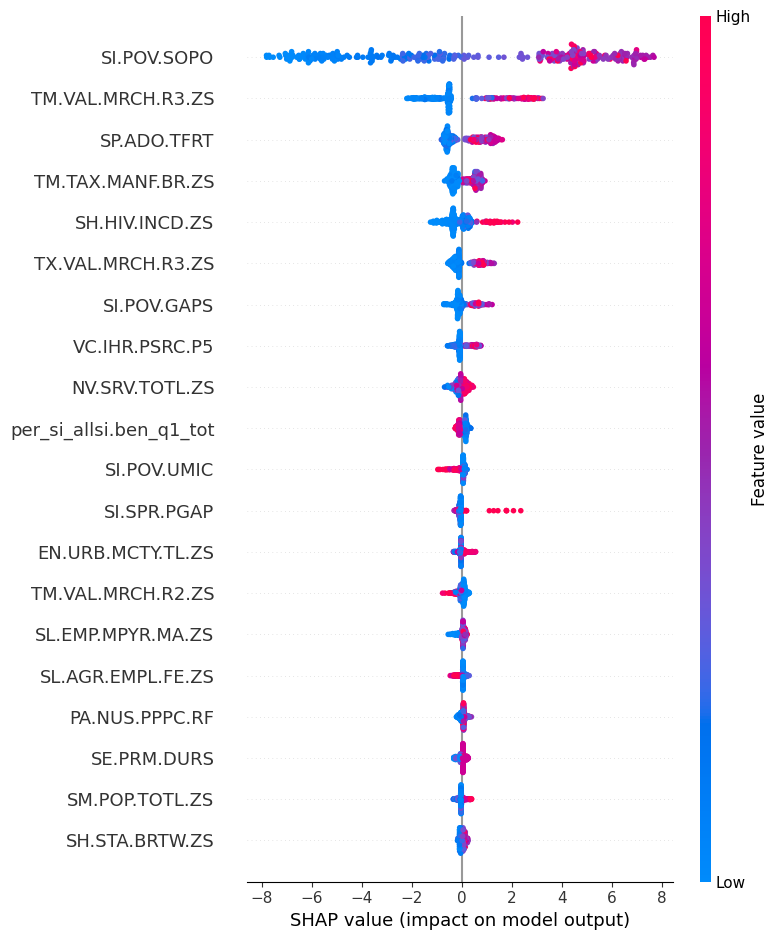

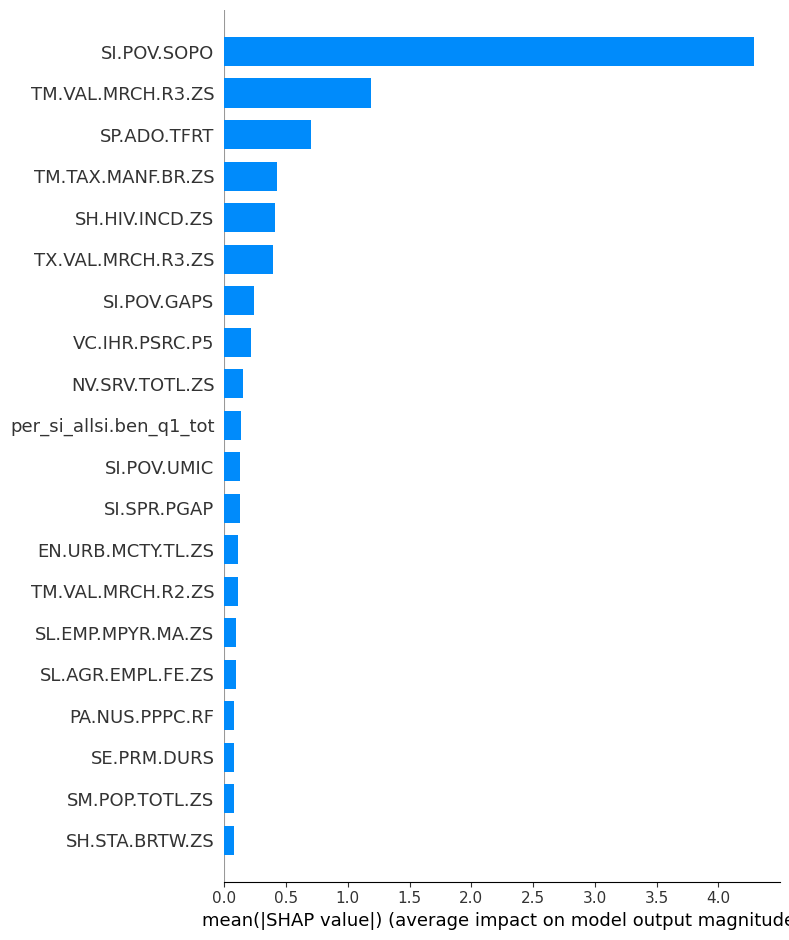

In [17]:
# SHAP analysis
import shap
import matplotlib.pyplot as plt

# Get the underlying XGBoost model from the pipeline
xgb_model = best_model.named_steps['model']

# Apply the scaler to transform the data first
X_train_scaled = best_model.named_steps['scaler'].transform(X_train)
X_test_scaled = best_model.named_steps['scaler'].transform(X_test)

# Initialize SHAP explainer with the XGBoost model only
explainer = shap.TreeExplainer(xgb_model)

# Calculate SHAP values on the scaled data
shap_values = explainer.shap_values(X_test_scaled)

# Save SHAP values
shap_values_df = pd.DataFrame(shap_values, columns=feature_columns)
shap_values_df.to_csv(f'{FEATURE_IMPORTANCE_DIR}/shap_values_{FILE_SUFFIX}.csv', index=False)
print(f"\nSHAP values saved to {FEATURE_IMPORTANCE_DIR}/shap_values_{FILE_SUFFIX}.csv")

# Plot SHAP summary
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_columns, show=False)
plt.tight_layout()
plt.savefig(f'{FEATURE_IMPORTANCE_DIR}/shap_summary_{FILE_SUFFIX}.png', dpi=300, bbox_inches='tight')
plt.show()

# Additionally, create a bar plot of SHAP values
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_columns, plot_type="bar", show=False)
plt.tight_layout()
plt.savefig(f'{FEATURE_IMPORTANCE_DIR}/shap_importance_{FILE_SUFFIX}.png', dpi=300, bbox_inches='tight')
plt.show()